# Project 2: Lane Detection

# Our Pipeline to approach this problem:
    1. Prepare the Input
    2. Detect Lane Candidates
    3. Refine Lane Detection
    4. Predict Curvature and Turn predictions.

## Step 1: Preparing the Input

In [25]:
# Import Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import moviepy
from moviepy.editor import VideoFileClip

In [2]:
# Camera Matrix
K = np.array([[  1.15422732e+03,   0.00000000e+00,   6.71627794e+02],
     [  0.00000000e+00,   1.14818221e+03,   3.86046312e+02],
     [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]], dtype="float32")

# Distortion Coefficients
dist = np.array([[ -2.42565104e-01,  -4.77893070e-02,  -1.31388084e-03,  -8.79107779e-05, 2.20573263e-02]], dtype="float32")

####     1. Create sample images of straight and curved lanes.

In [3]:
# Create 6 Sample Images - 3 straight and 3 curved samples.
def create_sample_images(path, straight_or_curved, beggining_number):
    cap = cv2.VideoCapture(path)
    sample_type = straight_or_curved
    index = 0
    count = int(beggining_number)
    while (True):
        # from 300th frame we get to see straight lanes.
        ret, frame = cap.read()
        if (index > sample_type) and count != int(beggining_number) + 3:
            name = "Results/Original/Sample_Image_" + str(count) + ".jpg"
            cv2.imwrite(name, frame)
            count += 1
        if count == int(beggining_number) + 3:
            break
        index += 1

In [4]:
# Run only once!
create_sample_images('DataSet/project_video.mp4', 300, 1)# Straight Lanes
create_sample_images('DataSet/project_video.mp4', 30, 4)# Curved Lanes

#### 2. Undistorting Sample Images 

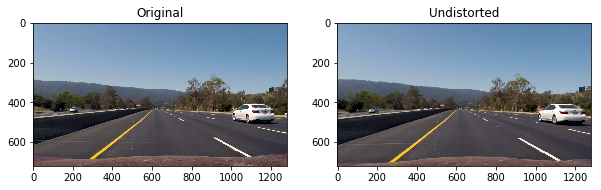

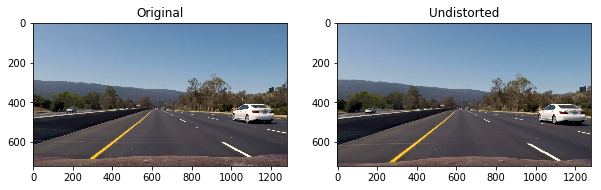

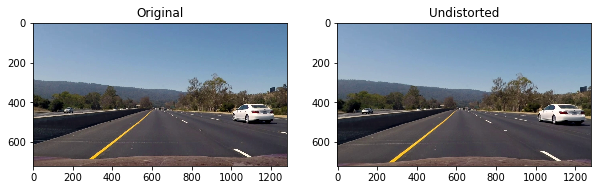

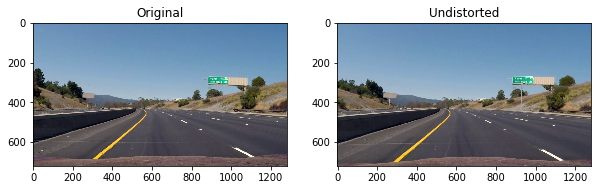

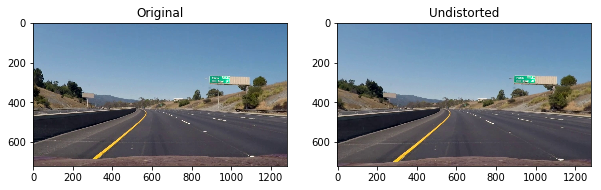

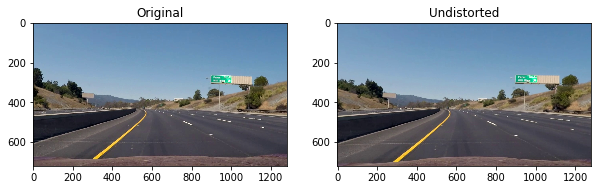

In [5]:
# Undistorting the Images
images = glob.glob('Results/Original/*.jpg')# Read all images in the folder.
images.sort()# to make sure images are read in same order
original = []

for index, image in enumerate(images):
    original_image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    original.append(original_image)
    undistortedImage = cv2.undistort(original_image, K, dist)# Undistorting the images.
    
    fig, axes = plt.subplots(1, 2, figsize = (10,10))
    
    axes[0].set_title("Original")
    axes[0].imshow(original_image)
    
    axes[1].set_title("Undistorted")
    axes[1].imshow(undistortedImage)
    
    path = 'Results/Undistorted/'
    name = path + image
    
    cv2.imwrite(name, undistortedImage)

#### 3. Getting the Bird's Eye View.

In [134]:
# Getting the 4 points for Homograghy
# Creating a Mouse Event Function to find the 4 points on straight lanes.
source_points = []
def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDBLCLK:
        mouseX,mouseY = x,y
        print(mouseX, mouseY)
        source_points.append([mouseX,mouseY])

image = cv2.imread("Results/Original/Sample_Image_1.jpg")
cv2.namedWindow('Finding the Four Points')
cv2.setMouseCallback('Finding the Four Points', draw_circle)

# Uncomment only if you want to select different points for estimating homoography
while True:
    print('Double Click to store new points; Otherwise PRESS ESC')
    print('Select point in clockwise manner starting from top-left')
    cv2.imshow('Finding the Four Points', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    break

Double Click to store new points; Otherwise PRESS ESC
Select point in clockwise manner starting from top-left
586 453
679 453
986 614
392 614


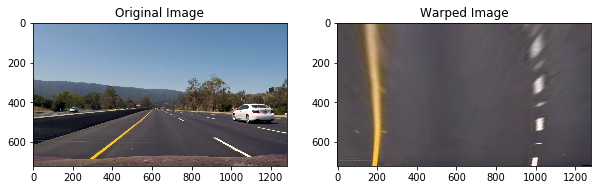

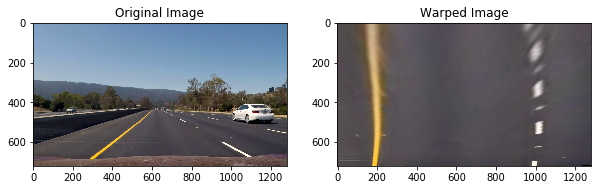

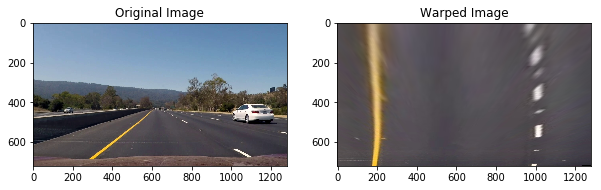

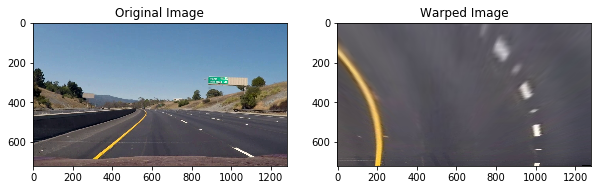

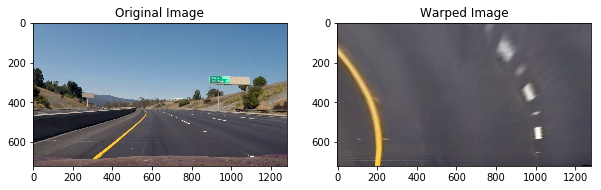

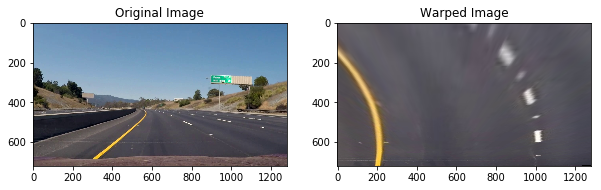

In [135]:
straight_lane = cv2.imread("Results/Original/Sample_Image_1.jpg")
w, h = straight_lane.shape[1],straight_lane.shape[0]
if len(source_points) == 0:
    source_points = [[583, 456],[686, 456],[890, 568],[444, 568]]# After million trial and errors!
src = np.array(source_points,dtype='f')
dst = np.array([[200,200], [1000 ,200], [1000 ,700], [200 ,700]],dtype='f')# Let's do operation only on two lanes.
H,flag = cv2.findHomography(src,dst)

# Function can be used directly later on.
def BirdsView(normal_image):
    warped = cv2.warpPerspective(normal_image,H,(w,h))
    return warped

images = glob.glob('Results/Original/*.jpg')# Read all images in the folder.
images.sort()
warpedImages=[]
for index, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    untouchedImage= originalImage.copy()
    warped = BirdsView(untouchedImage)
    warpedImages.append(warped)
    name = 'Results/Warped/' + image[-18:]
    cv2.imwrite(name, warped)# Storing in the warped folder.
    fig, axes= plt.subplots(1,2,figsize=(10,10))

    axes[0].imshow(originalImage)
    axes[0].set_title("Original Image")

    axes[1].imshow(warped)
    axes[1].set_title("Warped Image")

#### 4. Experimenting with HLS Colorspaces - for yellow and white lane detection

##### Lane lines are colored white or yellow. We can filter out any unnecessary colors so that we can make sure our pipeline is processing only lane lines.  We found most promising results in HLS color space.

In [136]:
def convert_2_binary(image, color_space, threshold, channel=0):
    '''Takes an image, converts into a colorspace,
        applies the threshold on the channel and returns the binary version of the image'''
    color_space = cv2.cvtColor(image, color_space)
    extracted_channel = color_space[:,:,channel]
    binary_image = np.zeros_like(extracted_channel)
    binary_image[(extracted_channel >= threshold[0]) & (extracted_channel <= threshold[1])] = 1
    return binary_image

Text(0.5, 1.0, 'S')

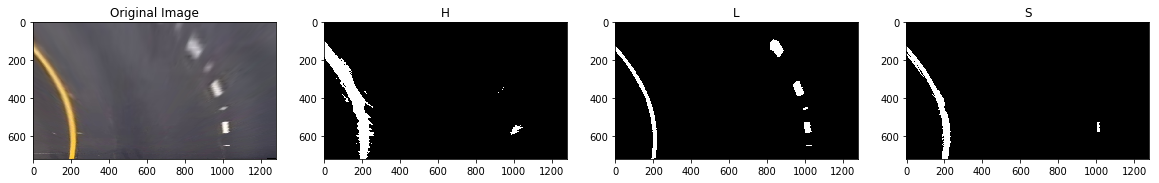

In [137]:
# Testing HLS colorspace on our sample images

fig, axes = plt.subplots(1,4,figsize=(20,20))# HLS ColorSpace - 3 channels

image = warpedImages[4]# Testing on the first warped sample.

# threshold = [150, 255]# Threshold range for both yellow and white

axes[0].imshow(image)
axes[0].set_title("Original Image")

# Converting to HLS Colorspace - HLS gives the best result detecting lanes.
h = convert_2_binary(image, cv2.COLOR_RGB2HLS , [15,45], 0)# h will always be able extract yellow for us
axes[1].imshow(h,cmap='gray')
axes[1].set_title("H")

l = convert_2_binary(image, cv2.COLOR_RGB2HLS , [150,255], 1)# l will help extract white.
axes[2].imshow(l,cmap='gray')
axes[2].set_title("L")

s = convert_2_binary(image, cv2.COLOR_RGB2HLS , [100,255], 2)
axes[3].imshow(s,cmap='gray')
axes[3].set_title("S")

#### 4. Sobel X, Y and XY Gradients

In [138]:
def ApplySobel(warpedimage, threshold, sobelType, kernelSize=3):
    
    # Sobel takes input in gray
    gray = cv2.cvtColor(warpedimage, cv2.COLOR_RGB2GRAY) 
    
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize=kernelSize)# keeping the output datatype to some higher forms
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize=kernelSize)
    
    # Magnitudes in different directions
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobel_xy= np.sqrt(sobelx**2 + sobely**2)
    
    # Direction
    direction = np.arctan2(abs_sobely,abs_sobelx)

    if(sobelType=='x'):
        res = abs_sobelx
    elif(sobelType=='y'):
        res = abs_sobely
    elif(sobelType=='xy'):
        res = abs_sobel_xy
    else:
        res = direction
        
    # Normalizing the sobel image
    img = np.uint8((res* 255)/np.max(res))# Converting back to np.uint8
    binary_output = np.zeros_like(img)
    binary_output[(img > threshold[0]) & (img < threshold[1])]=1
    return binary_output

Text(0.5, 1.0, 'Sobel Direction')

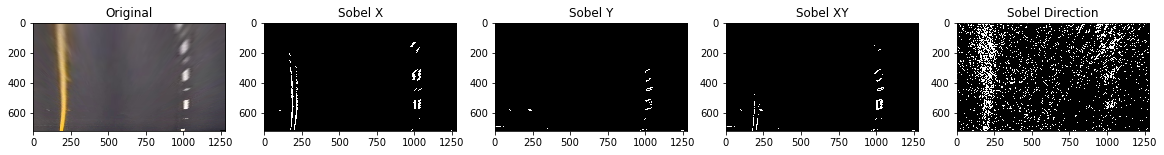

In [139]:
# Plotting gradients in different directions.
fig, axes= plt.subplots(1,5,figsize=(20,20))

threshold=[20,100]
image = warpedImages[2]
axes[0].imshow(image)
axes[0].set_title("Original")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

sobelx=ApplySobel(image,threshold,'x')
axes[1].imshow(sobelx, cmap = 'gray')
axes[1].set_title("Sobel X") # Looks the best

sobely=ApplySobel(image,threshold,'y')
axes[2].imshow(sobely, cmap = 'gray')
axes[2].set_title("Sobel Y")

sobelxy=ApplySobel(image,threshold,'xy')
axes[3].imshow(sobelxy, cmap = 'gray')
axes[3].set_title("Sobel XY") # Can be combined with Sobel X for better results.

sobeldir=ApplySobel(image,threshold,'dir')
axes[4].imshow(sobeldir, cmap = 'gray')
axes[4].set_title("Sobel Direction")

#### 5. Detecting lanes.

Detected Lanes: 


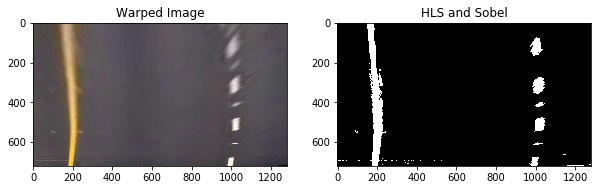

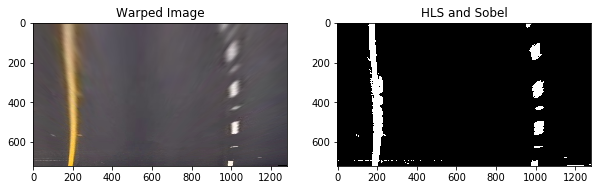

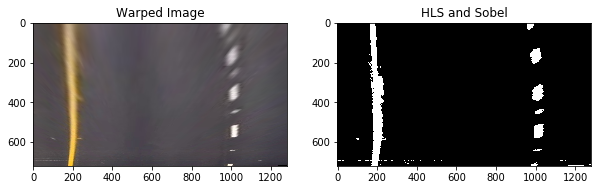

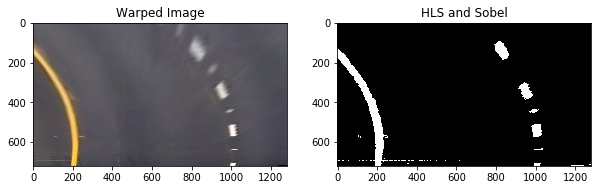

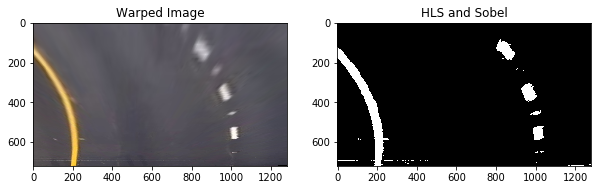

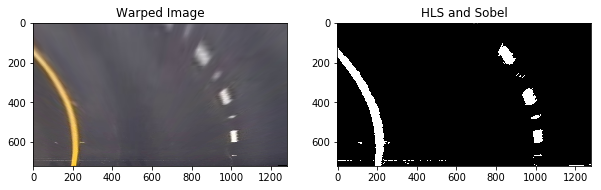

In [140]:
def detect_lanes(warpedImage, sobel_threshold):
    h_channel= convert_2_binary(warpedImage,cv2.COLOR_RGB2HLS,[15,45],0)
    l_channel = convert_2_binary(warpedImage,cv2.COLOR_RGB2HLS,[150,255],1)
    s_channel = convert_2_binary(warpedImage,cv2.COLOR_RGB2HLS,[100,255],2)
    
    sobelx = ApplySobel(warpedImage, sobel_threshold, 'x')
    sobelxy = ApplySobel(warpedImage, sobel_threshold, 'xy')
    binary = np.zeros_like(s_channel)
    binary[(((h_channel == 1) & (s_channel==1)) | (l_channel==1)) | ((sobelx == 1) | (sobelxy == 1))  ] = 1
    return binary

print("Detected Lanes: ")
for index,warped in enumerate(warpedImages):
    binary_detected_lane = detect_lanes(warped, [20,150])
    fig, axes= plt.subplots(1,2,figsize=(10,10))
    axes[0].imshow(warped)
    axes[0].set_title("Warped Image")
    axes[1].imshow(binary_detected_lane, cmap='gray')
    axes[1].set_title("HLS and Sobel")

## Step 2. Detecting Lane Candidates.

#### 6. Histogram of Lane Pixels.

In [141]:
# Plotting Histogram
def Histogram(warpedimage):
    return np.sum(warpedimage[warpedimage.shape[0]//2:,:], axis=0)# Summing only lower half.

Text(0.5, 1.0, 'Histogram')

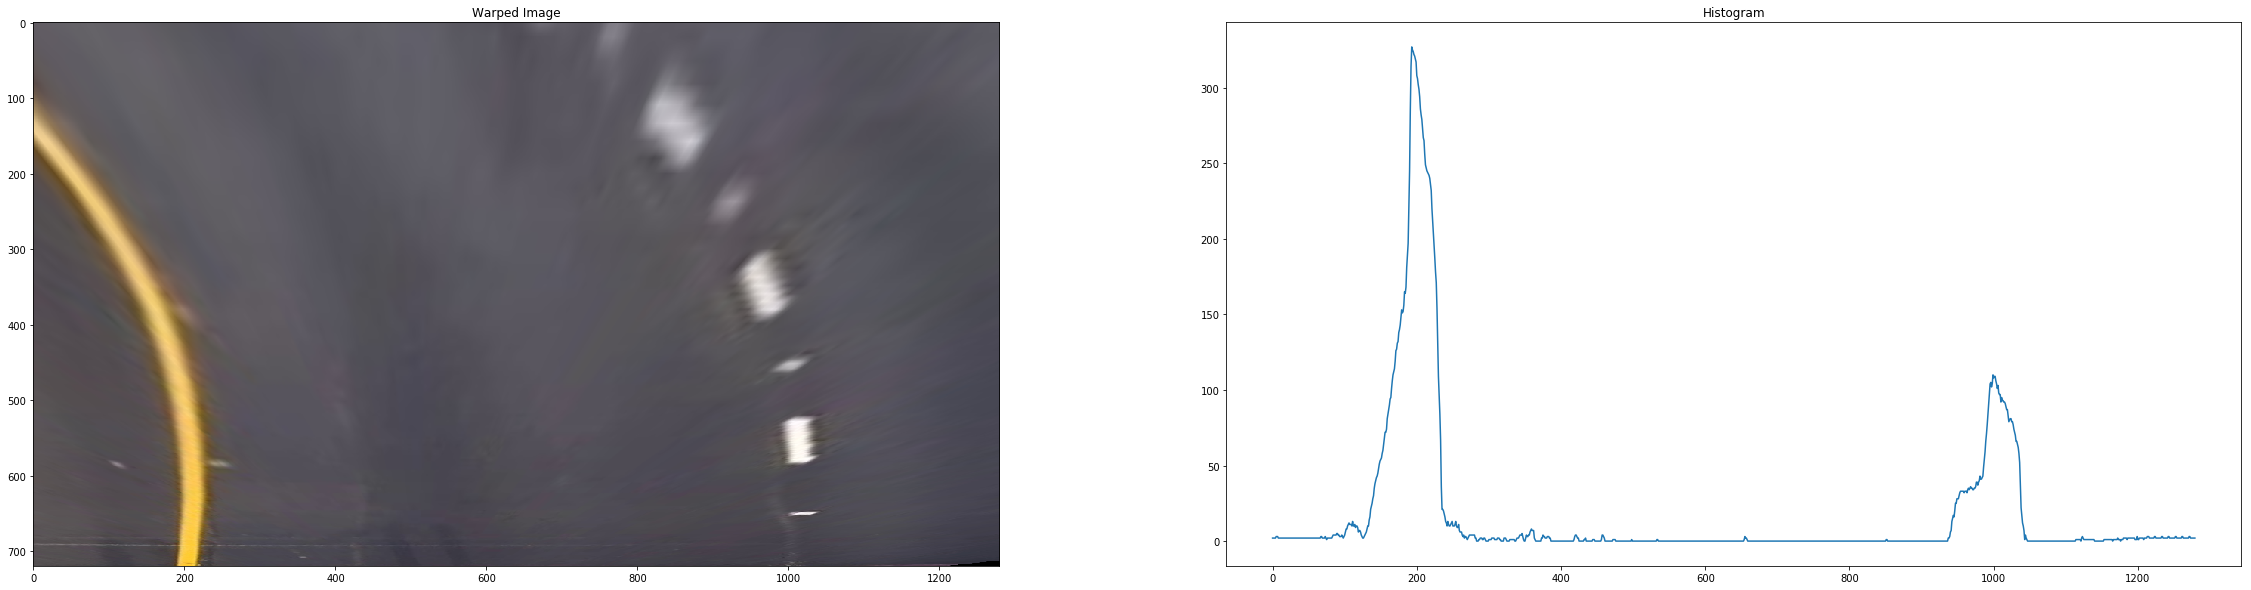

In [142]:
# Testing
fig, axes= plt.subplots(1,2,figsize=(40,10))
img= warpedImages[4]
axes[0].imshow(img)
axes[0].set_title("Warped Image")
filtered_image = detect_lanes(img, [20,100])
histogram = Histogram(filtered_image)
axes[1].plot(histogram)
axes[1].set_title("Histogram")

#### 7. Sliding Window Search For Lane Orientation Determination

In [143]:
def SlidingWindowSearch(binary, plot=False):
    histogram = Histogram(binary)
    
    # Create an output image to draw on
    out_img = np.dstack((binary, binary, binary))*255
    
    # Find the peak of the left and right halves of the histogram which will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of sliding windows
    n = 9
    
    # Height of windows
    window_height = np.int(binary.shape[0]/n) 
    
    # Identify the x and y positions of all nonzero pixels
    nonzero = binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    left_x_current = left_x_base
    right_x_current = right_x_base
    
    # Width of the windows +/- margin
    margin = 100
    
    # Minimum number of pixels found to recenter window
    min_pixels = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane = []
    right_lane = []

    # Step through the windows one by one
    for window in range(n):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height
        win_x_left_low = left_x_current - margin
        win_x_left_high = left_x_current + margin
        win_x_right_low = right_x_current - margin
        win_x_right_high = right_x_current + margin
        
        # Draw the windows on the visualization image
        if(plot==True):
            cv2.rectangle(out_img,(win_x_left_low,win_y_low),(win_x_left_high,win_y_high),(0,0,255), 2) 
            cv2.rectangle(out_img,(win_x_right_low,win_y_low),(win_x_right_high,win_y_high),(255,0,0), 2) 
            
        # Identify the nonzero pixels in x and y within the window
        good_left = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_x_left_low) &  (nonzero_x < win_x_left_high)).nonzero()[0]
        good_right = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_x_right_low) &  (nonzero_x < win_x_right_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane.append(good_left)
        right_lane.append(good_right)
        
        # If you found > min_pixels pixels, recenter next window on their mean position
        if len(good_left) > min_pixels:
            left_x_current = np.int(np.mean(nonzero_x[good_left]))
        if len(good_right) > min_pixels:        
            right_x_current = np.int(np.mean(nonzero_x[good_right]))

    # Concatenate the arrays of indices
    left_lane = np.concatenate(left_lane)
    right_lane = np.concatenate(right_lane)

    # Extract left and right line pixel positions
    left_x = nonzero_x[left_lane]
    left_y = nonzero_y[left_lane] 
    right_x = nonzero_x[right_lane]
    right_y = nonzero_y[right_lane] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
#     left_fit = np.polyfit(left_y, left_x, 1)
#     right_fit = np.polyfit(right_y, right_x, 1)

    return left_fit,right_fit,left_lane,right_lane,out_img

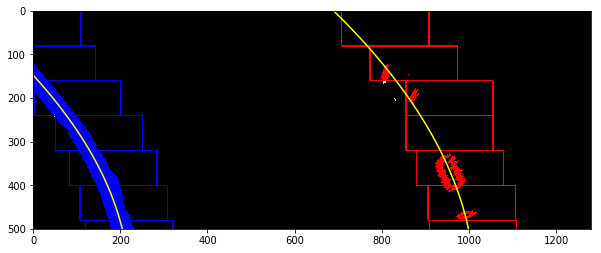

In [118]:
def VisualizeSlidingWindow(binary, left_fit, right_fit, left_lane, right_lane, out_img):
    nonzero = binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    out_img[nonzero_y[left_lane], nonzero_x[left_lane]] = [0, 0, 255]# in RGB format # Blue - left
    out_img[nonzero_y[right_lane], nonzero_x[right_lane]] = [255, 0, 0]# in RGB Format # Red - left
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#     left_fitx = left_fit[0]*ploty + left_fit[1]
#     right_fitx = right_fit[0]*ploty + right_fit[1]
    

    
    plt.figure(figsize=(10,10))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(500, 0)

l,r,ld,rd,o = SlidingWindowSearch(filtered_image, plot=True)
VisualizeSlidingWindow(filtered_image,l,r,ld,rd,o)


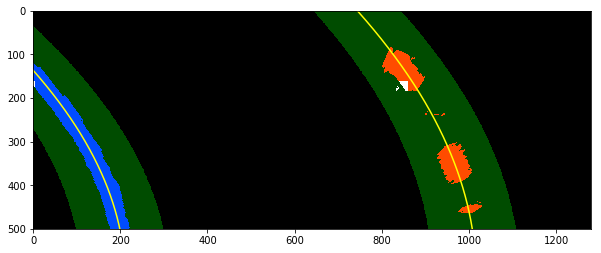

In [144]:
def VisualizeLaneDetection(binary, left_fit,right_fit, left_lane, right_lane,out_img):
    margin = 100
    nonzero = binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    out_img[nonzero_y[left_lane], nonzero_x[left_lane]] = [0, 0, 255]
    out_img[nonzero_y[right_lane], nonzero_x[right_lane]] = [255, 0, 0]
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#     left_fitx = left_fit[0]*ploty + left_fit[1]
#     right_fitx = right_fit[0]*ploty + right_fit[1]

   
    
 
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary, binary, binary))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzero_y[left_lane], nonzero_x[left_lane]] = [0, 0, 255]
    out_img[nonzero_y[right_lane], nonzero_x[right_lane]] = [255, 0, 0]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    
    plt.figure(figsize=(10,10))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(500, 0)

l,r,ld,rd,o=SlidingWindowSearch(filtered_image, plot=False)
VisualizeLaneDetection(filtered_image,l,r,ld,rd,o)

In [145]:
# Paint Lane on the Unwarped Image.

def DrawLine(normal_image, binary, left_fit, right_fit):
    
    h,w= binary.shape
    Minv = cv2.getPerspectiveTransform(dst, src)# Getting Inverse Homography.
    ploty = np.linspace(0, binary.shape[0]-1, num = binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] # A.x^2 + B.x + C
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
#     left_fitx = left_fit[0]*ploty + left_fit[1]
#     right_fitx = right_fit[0]*ploty + right_fit[1]
    zeros = np.zeros_like(binary).astype(np.uint8)
    color_warp = np.dstack((zeros, zeros, zeros))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 255)) # Detected Lane in Yellow
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255, 0, 0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255, 0, 0), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h))
    #axes[index+1].imshow(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(normal_image, 0.7, newwarp, 0.5, 0)
    return result

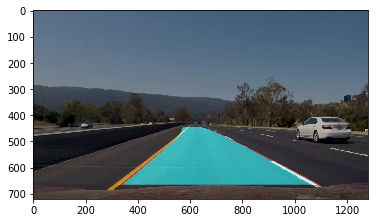

In [146]:
# Test it
images.sort()
originalImage = images[0]
originalImage = cv2.imread(originalImage)
originalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
returnedOutput =  SlidingWindowSearch(filtered_image)
left_fit=returnedOutput[0]
right_fit=returnedOutput[1]
finalImage=DrawLine(originalImage,filtered_image,left_fit,right_fit)
plt.imshow(finalImage)

In [147]:
def CalculateRadiusOfCurvature(binary,left_fit,right_fit):
    
    
    # The U.S. Interstate Highway System uses a 12-foot (3.7 m) 
    # standard for lane width, while narrower lanes are used on lower classification roads.

    ym = 30/500 # meters per pixel in y dimension
    xm = 3.7/800 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#     left_fitx = left_fit[0]*ploty + left_fit[1]
#     right_fitx = right_fit[0]*ploty + right_fit[1]

    car_position= binary.shape[1]/2
    
    # Fit new polynomials to x,y 
    left_fit_cr = np.polyfit(ploty*ym, leftx*xm, 2)
    right_fit_cr = np.polyfit(ploty*ym, rightx*xm, 2)
#     left_fit_cr = np.polyfit(ploty*ym, leftx*xm, 1)
#     right_fit_cr = np.polyfit(ploty*ym, rightx*xm, 1)

    
    # Calculate the new radius of curvature
    y_eval=np.max(ploty)
    
    left_curve_radius = ((1 + (2*left_fit_cr[0]*y_eval*ym + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve_radius = ((1 + (2*right_fit_cr[0]*y_eval*ym + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    actual_position= (left_lane_bottom+ right_lane_bottom)/2
    
    distance= (car_position - actual_position)* xm
    
    return (left_curve_radius + right_curve_radius)/2, distance

In [148]:
def pipeline(anyImage):
    w,h = anyImage.shape[1], anyImage.shape[0]
    anyImage= cv2.cvtColor(anyImage, cv2.COLOR_BGR2RGB)
    undistortedImage= cv2.undistort(anyImage, K, dist)
    warpedImage= cv2.warpPerspective(undistortedImage,H,((w,h)))
    combined_Image= detect_lanes(warpedImage, [20,150])
    returnedOutput =  SlidingWindowSearch(combined_Image)
    left_fit=returnedOutput[0]
    right_fit=returnedOutput[1]
    
    finalImage=DrawLine(anyImage,combined_Image,left_fit,right_fit)       
    radius, distance = CalculateRadiusOfCurvature(combined_Image,left_fit,right_fit)
    cv2.putText(finalImage,"Lane Curvature is " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,0),2)
    
    if distance > 0:
        cv2.putText(finalImage,"Vehicle is {:2f}".format(distance)+ "m right of center", (100,150), 2, 1, (255,255,0),2)
        if distance > 1:
            cv2.putText(finalImage,"<---- Turn Left", (100,200), 2, 1, (255,255,0),2)
        else:
            cv2.putText(finalImage,"Keep moving Straight", (100,200), 2, 1, (255,255,0),2)
    else:
        cv2.putText(finalImage,"Vehicle is {:2f}".format(-1*distance)+ "m left of center", (100,150), 2, 1, (255,255,0),2)
        if distance < -1:
            cv2.putText(finalImage,"Turn Right ---->", (100,200), 2, 1, (255,255,0),2)
        else:
            cv2.putText(finalImage,"Keep moving Straight", (100,200), 2, 1, (255,255,0),2)
    
    return finalImage

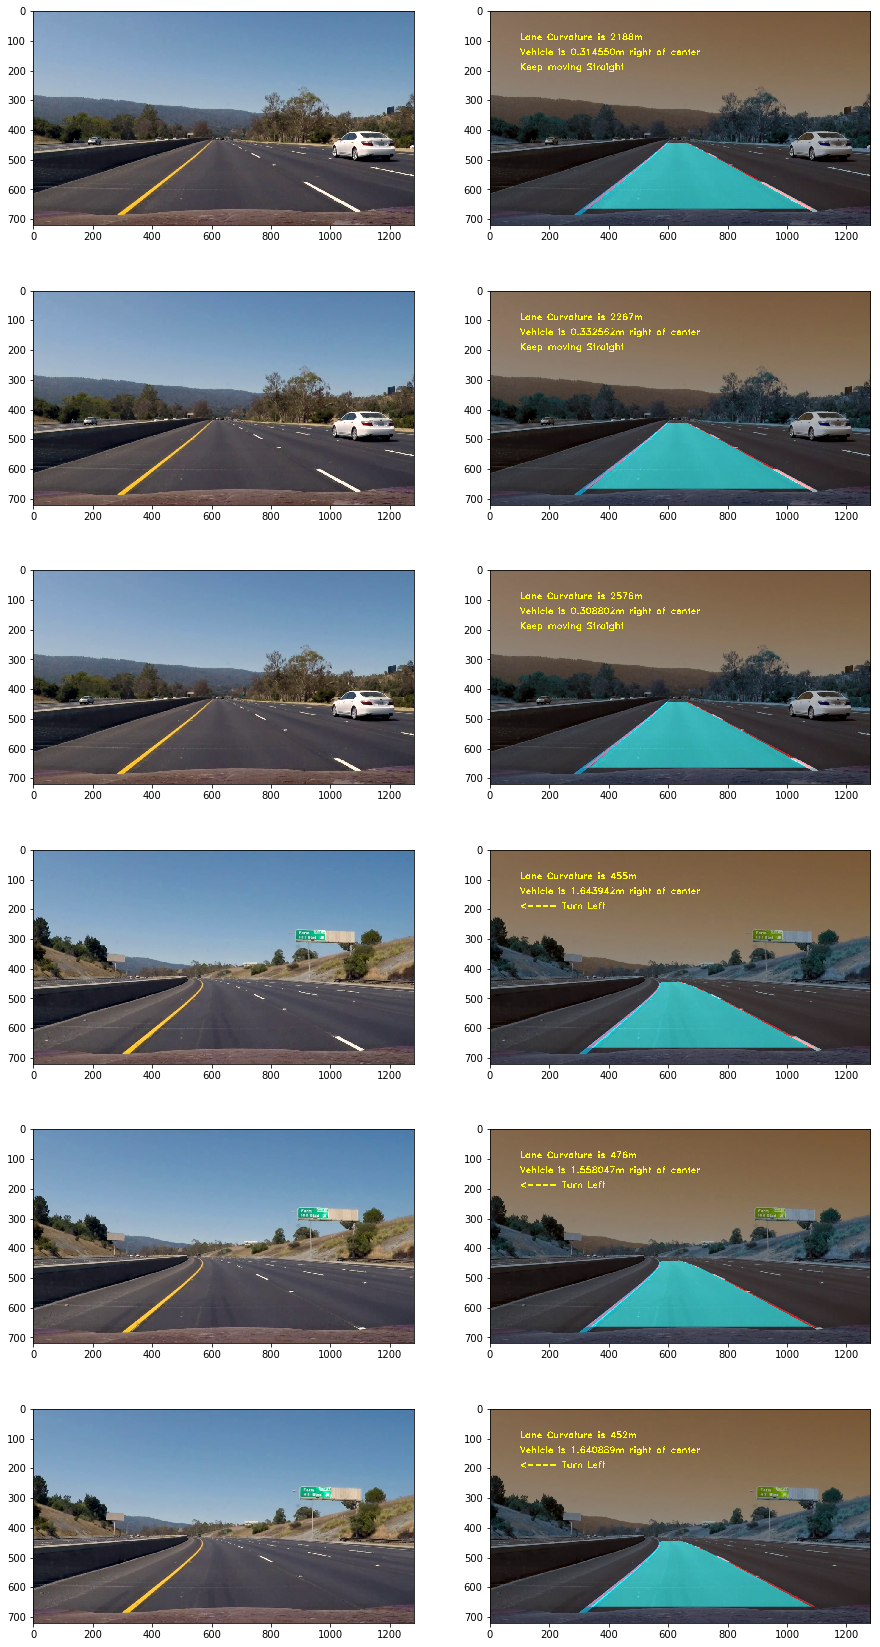

In [149]:
fig, axes= plt.subplots(6,2,figsize=(15,30))

images = glob.glob('Results/Original/*.jpg') # Reading test_images.
images.sort()

for index, image_name in enumerate(images):
    image= cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
    final_image = pipeline(image)
    name = 'Results/LaneDetection/' + str(image_name[-18:])
    cv2.imwrite(name+'.jpg', cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB))
    axes[index,0].imshow(image)
    axes[index,1].imshow(final_image)

In [125]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 4min 20s, sys: 3.16 s, total: 4min 23s
Wall time: 3min 22s


In [133]:
video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

t:   0%|          | 2/485 [00:00<00:35, 13.44it/s, now=None]

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
CPU times: user 1min 36s, sys: 1.36 s, total: 1min 38s
Wall time: 1min 15s
